# Differential gene expression analysis - data pre-processing for pseudobulk
Using the merged data set.

## 1. Environment setup

In [1]:
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import random
import sc_toolbox
import anndata

sc.settings.verbosity = 0

## 2. Preparing the dataset

In [2]:
adata = sc.read("/home/sch/schonner/MaPra/merged_data.h5ad")
adata

AnnData object with n_obs × n_vars = 87871 × 23767
    obs: 'author_annotation', 'scDblFinder_score', 'scDblFinder_class', 'manual_celltype_annotation', 'batch', 'condition', 'doublet_score', 'predicted_doublet', 'timepoint', 'author_annotation_coarse', 'dataset', 'fibrotic/control', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'low_hierarchy', 'high_hierarchy', 'harmonized_anno', 'coarse_harmonized_anno', 'low_hierarchy_fine', 'high_hierarchy_fine', 'low_hierarchy_coarse', 'high_hierarchy_coarse'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches

### We need label (which contains the condition label), replicate and cell_type columns of the .obs

---> condition, batch and coarse_harmonized_anno in this data set

In [3]:
adata.obs[:5]

,author_annotation,scDblFinder_score,scDblFinder_class,manual_celltype_annotation,batch,condition,doublet_score,predicted_doublet,timepoint,author_annotation_coarse,...,log1p_total_counts_hb,pct_counts_hb,low_hierarchy,high_hierarchy,harmonized_anno,coarse_harmonized_anno,low_hierarchy_fine,high_hierarchy_fine,low_hierarchy_coarse,high_hierarchy_coarse
AAACCTGAGGACATTA-1_xie,Col13a1,0.021293,singlet,Myofibroblasts,1_xie,untreated,NaN,NaN,NaN,NaN,...,0.0,0.0,Adventitial fibroblasts ∈ Myofibroblasts ∈ Myo...,Group1,Myofibroblasts,Myofibroblasts,Myofibroblasts = Myofibroblasts ∋ Adventitial ...,Group1,Myofibroblasts = Myofibroblasts = Fibroblasts ...,Group7
AAACCTGCAGTCGTGC-1_xie,Myofibroblasts,0.000934,singlet,Peribronchial fibroblasts,1_xie,untreated,NaN,NaN,NaN,NaN,...,0.0,0.0,Peribronchial fibroblasts = Peribronchial fibr...,Group13,Peribronchial fibroblasts,Fibroblasts,NONE = Peribronchial fibroblasts = Peribronchi...,Group8,Fibroblasts = Fibroblasts = NONE = UNRESOLVED ...,Group5
AAACCTGCATGAAGTA-1_xie,Lipofibroblasts,0.000118,singlet,Alveolar macrophages,1_xie,untreated,NaN,NaN,NaN,NaN,...,0.0,0.0,UNRESOLVED = Alveolar macrophages = Alveolar m...,Group16,Alveolar macrophages,Alveolar macrophages,Alveolar macrophages = Alveolar macrophages ∈ ...,Group3,Alveolar macrophages = Alveolar macrophages = ...,Group2
AAACCTGTCTCGCATC-1_xie,Myofibroblasts,0.000478,singlet,Peribronchial fibroblasts,1_xie,untreated,NaN,NaN,NaN,NaN,...,0.0,0.0,Peribronchial fibroblasts = Peribronchial fibr...,Group13,Peribronchial fibroblasts,Fibroblasts,NONE = Peribronchial fibroblasts = Peribronchi...,Group8,Fibroblasts = Fibroblasts = NONE = UNRESOLVED ...,Group5
AAACGGGTCCTAGAAC-1_xie,Myofibroblasts,0.000669,singlet,Peribronchial fibroblasts,1_xie,untreated,NaN,NaN,NaN,NaN,...,0.0,0.0,Peribronchial fibroblasts = Peribronchial fibr...,Group13,Peribronchial fibroblasts,Fibroblasts,NONE = Peribronchial fibroblasts = Peribronchi...,Group8,Fibroblasts = Fibroblasts = NONE = UNRESOLVED ...,Group5


### We need to work with raw counts so we check that .X indeed contains raw counts and put them into the counts layer of our AnnData object.

In [4]:
np.max(adata.layers["raw_counts"])

25996.0

In [5]:
adata.layers["counts"] = adata.layers["raw_counts"].copy()   # normally: adata.X.copy()

[Text(0.5, 1.0, 'Raw counts histogram'), Text(0, 0.5, 'Frequency')]

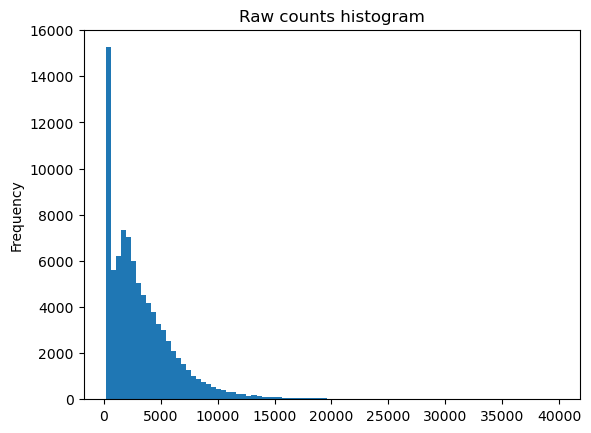

In [6]:
column_sums = np.sum(adata.layers["counts"], axis=1)
plt.hist(column_sums, bins=90)   # plot the sums of the raw counts as a sanity check
plt.gca().set(title='Raw counts histogram', ylabel='Frequency')

### Number of samples per condition

In [7]:
print("Asbestos: ", len(adata[adata.obs["condition"] == "asbestos"]))
print("Bleomycin: ", len(adata[adata.obs["condition"] == "bleomycin"]))
print("Nintedanib: ", len(adata[adata.obs["condition"] == "nintedanib"]))
print("Saline: ", len(adata[adata.obs["condition"] == "saline"]))
print("Untreated: ", len(adata[adata.obs["condition"] == "untreated"]))

Asbestos:  7117
Bleomycin:  42899
Nintedanib:  0
Saline:  6360
Untreated:  31495


## 3. Pseudobulk

In [8]:
# create patient-condition combinations
adata.obs["sample"] = [
    f"{rep}_{l}" for rep, l in zip(adata.obs["batch"], adata.obs["condition"])
]

In [9]:
# clean up the cell type names
adata.obs["coarse_harmonized_anno"] = [ct.replace(" ", "_") for ct in adata.obs["coarse_harmonized_anno"]]
adata.obs["coarse_harmonized_anno"] = [ct.replace("+", "") for ct in adata.obs["coarse_harmonized_anno"]]
adata.obs["coarse_harmonized_anno"] = [ct.replace(".", "_") for ct in adata.obs["coarse_harmonized_anno"]]
adata.obs["coarse_harmonized_anno"] = [ct.replace("-", "_") for ct in adata.obs["coarse_harmonized_anno"]]

In [10]:
# set categorical metadata to be indeed categorical to create pseudobulks 
adata.obs['batch'] = adata.obs["batch"].astype(str)
adata.obs['condition'] = adata.obs["condition"].astype(str)
adata.obs['sample'] = adata.obs["sample"].astype(str)
adata.obs['coarse_harmonized_anno'] = adata.obs["coarse_harmonized_anno"].astype(str)

adata.obs["batch"] = adata.obs["batch"].astype("category")
adata.obs["condition"] = adata.obs["condition"].astype("category")
adata.obs["sample"] = adata.obs["sample"].astype("category")
adata.obs["coarse_harmonized_anno"] = adata.obs["coarse_harmonized_anno"].astype("category")

In [11]:
adata.obs[:5]

,author_annotation,scDblFinder_score,scDblFinder_class,manual_celltype_annotation,batch,condition,doublet_score,predicted_doublet,timepoint,author_annotation_coarse,...,pct_counts_hb,low_hierarchy,high_hierarchy,harmonized_anno,coarse_harmonized_anno,low_hierarchy_fine,high_hierarchy_fine,low_hierarchy_coarse,high_hierarchy_coarse,sample
AAACCTGAGGACATTA-1_xie,Col13a1,0.021293,singlet,Myofibroblasts,1_xie,untreated,NaN,NaN,NaN,NaN,...,0.0,Adventitial fibroblasts ∈ Myofibroblasts ∈ Myo...,Group1,Myofibroblasts,Myofibroblasts,Myofibroblasts = Myofibroblasts ∋ Adventitial ...,Group1,Myofibroblasts = Myofibroblasts = Fibroblasts ...,Group7,1_xie_untreated
AAACCTGCAGTCGTGC-1_xie,Myofibroblasts,0.000934,singlet,Peribronchial fibroblasts,1_xie,untreated,NaN,NaN,NaN,NaN,...,0.0,Peribronchial fibroblasts = Peribronchial fibr...,Group13,Peribronchial fibroblasts,Fibroblasts,NONE = Peribronchial fibroblasts = Peribronchi...,Group8,Fibroblasts = Fibroblasts = NONE = UNRESOLVED ...,Group5,1_xie_untreated
AAACCTGCATGAAGTA-1_xie,Lipofibroblasts,0.000118,singlet,Alveolar macrophages,1_xie,untreated,NaN,NaN,NaN,NaN,...,0.0,UNRESOLVED = Alveolar macrophages = Alveolar m...,Group16,Alveolar macrophages,Alveolar_macrophages,Alveolar macrophages = Alveolar macrophages ∈ ...,Group3,Alveolar macrophages = Alveolar macrophages = ...,Group2,1_xie_untreated
AAACCTGTCTCGCATC-1_xie,Myofibroblasts,0.000478,singlet,Peribronchial fibroblasts,1_xie,untreated,NaN,NaN,NaN,NaN,...,0.0,Peribronchial fibroblasts = Peribronchial fibr...,Group13,Peribronchial fibroblasts,Fibroblasts,NONE = Peribronchial fibroblasts = Peribronchi...,Group8,Fibroblasts = Fibroblasts = NONE = UNRESOLVED ...,Group5,1_xie_untreated
AAACGGGTCCTAGAAC-1_xie,Myofibroblasts,0.000669,singlet,Peribronchial fibroblasts,1_xie,untreated,NaN,NaN,NaN,NaN,...,0.0,Peribronchial fibroblasts = Peribronchial fibr...,Group13,Peribronchial fibroblasts,Fibroblasts,NONE = Peribronchial fibroblasts = Peribronchi...,Group8,Fibroblasts = Fibroblasts = NONE = UNRESOLVED ...,Group5,1_xie_untreated


### Define the function we need to aggregate single cells into pseudo-replicates:
This function creates an AnnData object with one pseudo-replicate for each donor for a specified subpopulation from the original single-cell AnnData object. We do not filter our data.

In [12]:
def aggregate_and_filter(
    adata,
    cell_identity,
    donor_key="sample",
    condition_key="condition",
    cell_identity_key="coarse_harmonized_anno",
    obs_to_keep=[],  # which additional metadata to keep, e.g. gender, age, etc.
    replicates_per_patient=1,
):
    # subset adata to the given cell identity
    adata_cell_pop = adata[adata.obs[cell_identity_key] == cell_identity].copy()
    df = pd.DataFrame(columns=[*adata_cell_pop.var_names, *obs_to_keep])

    adata_cell_pop.obs[donor_key] = adata_cell_pop.obs[donor_key].astype("category")
    for i, donor in enumerate(donors := adata_cell_pop.obs[donor_key].cat.categories):
        print(f"\tProcessing donor {i+1} out of {len(donors)}...", end="\r")            
        adata_donor = adata_cell_pop[adata_cell_pop.obs[donor_key] == donor]
        # create replicates for each donor
        indices = list(adata_donor.obs_names)
        random.shuffle(indices)
        indices = np.array_split(np.array(indices), replicates_per_patient)
        for i, rep_idx in enumerate(indices):
            adata_replicate = adata_donor[rep_idx]
            # specify how to aggregate: sum gene expression for each gene for each donor and also keep the condition information
            agg_dict = {gene: "sum" for gene in adata_replicate.var_names}
            for obs in obs_to_keep:
                agg_dict[obs] = "first"
            # create a df with all genes, donor and condition info
            df_donor = pd.DataFrame(adata_replicate.X.A)
            df_donor.index = adata_replicate.obs_names
            df_donor.columns = adata_replicate.var_names
            df_donor = df_donor.join(adata_replicate.obs[obs_to_keep])
            # aggregate
            df_donor = df_donor.groupby(donor_key).agg(agg_dict)
            df_donor[donor_key] = donor
            df.loc[f"donor_{donor}_{i}"] = df_donor.loc[donor]
    print("\n")
    # create AnnData object from the df
    adata_cell_pop = sc.AnnData(
        df[adata_cell_pop.var_names], obs=df.drop(columns=adata_cell_pop.var_names)
    )
    return adata_cell_pop

### Create the AnnData object with pseudobulks:

In [13]:
obs_to_keep = ["dataset", "batch", "sample", "condition", "fibrotic/control", "coarse_harmonized_anno",
               "harmonized_anno", "author_annotation_coarse", "author_annotation"]   # obs columns that we want to keep

In [14]:
adata.X = adata.layers["counts"].copy()

In [15]:
adata.obs["coarse_harmonized_anno"].cat.categories

Index(['Aerocytes', 'Alveolar_macrophages', 'B_cells', 'Classical_monocytes',
       'Dendritic_cells', 'Endothelial', 'Epithelial', 'Fibroblasts',
       'Interstitial_macrophages', 'Myofibroblasts', 'NA', 'NK_cells',
       'Neutrophils', 'Non_classical_monocytes', 'SMCs', 'T_cells'],
      dtype='object')

In [16]:
# process first cell type separately...
cell_type = adata.obs["coarse_harmonized_anno"].cat.categories[0]
print(
    f'Processing {cell_type} (1 out of {len(adata.obs["coarse_harmonized_anno"].cat.categories)})...'
)
adata_pb = aggregate_and_filter(adata, cell_type, obs_to_keep=obs_to_keep)
for i, cell_type in enumerate(adata.obs["coarse_harmonized_anno"].cat.categories[1:]):
    print(
        f'Processing {cell_type} ({i+2} out of {len(adata.obs["coarse_harmonized_anno"].cat.categories)})...'
    )
    adata_cell_type = aggregate_and_filter(adata, cell_type, obs_to_keep=obs_to_keep)
    adata_pb = anndata.concat([adata_pb, adata_cell_type])   # --> adata_pb.concatenate(adata_cell_type) does not work!

Processing Aerocytes (1 out of 16)...
	Processing donor 16 out of 16...

Processing Alveolar_macrophages (2 out of 16)...
	Processing donor 24 out of 24...

Processing B_cells (3 out of 16)...
	Processing donor 24 out of 24...

Processing Classical_monocytes (4 out of 16)...
	Processing donor 24 out of 24...

Processing Dendritic_cells (5 out of 16)...
	Processing donor 52 out of 52...

Processing Endothelial (6 out of 16)...
	Processing donor 50 out of 50...

Processing Epithelial (7 out of 16)...
	Processing donor 52 out of 52...

Processing Fibroblasts (8 out of 16)...
	Processing donor 52 out of 52...

Processing Interstitial_macrophages (9 out of 16)...
	Processing donor 52 out of 52...

Processing Myofibroblasts (10 out of 16)...
	Processing donor 14 out of 14...

Processing NA (11 out of 16)...
	Processing donor 16 out of 16...

Processing NK_cells (12 out of 16)...
	Processing donor 8 out of 8...

Processing Neutrophils (13 out of 16)...
	Processing donor 41 out of 41...

Proce

### Saving data and first visualizations:

In [17]:
adata_pb.layers['counts'] = adata_pb.X.copy()

In [18]:
sc.pp.normalize_total(adata_pb, target_sum=1e6)
sc.pp.log1p(adata_pb)
sc.pp.pca(adata_pb)

In [19]:
adata_pb.obs["lib_size"] = np.sum(adata_pb.layers["counts"], axis=1)
adata_pb.obs["lib_size"] = adata_pb.obs["lib_size"].astype(float)   # --> not in example but important
adata_pb.obs["log_lib_size"] = np.log(adata_pb.obs["lib_size"])

Looking at the created pseudo-replicates on a PCA plot and color by all the available metadata to see if there are any confounding factors that we might want to include in the design matrix. We also add a lib_size and log_lib_size columns to check if there is a correlation between library size and PC components.

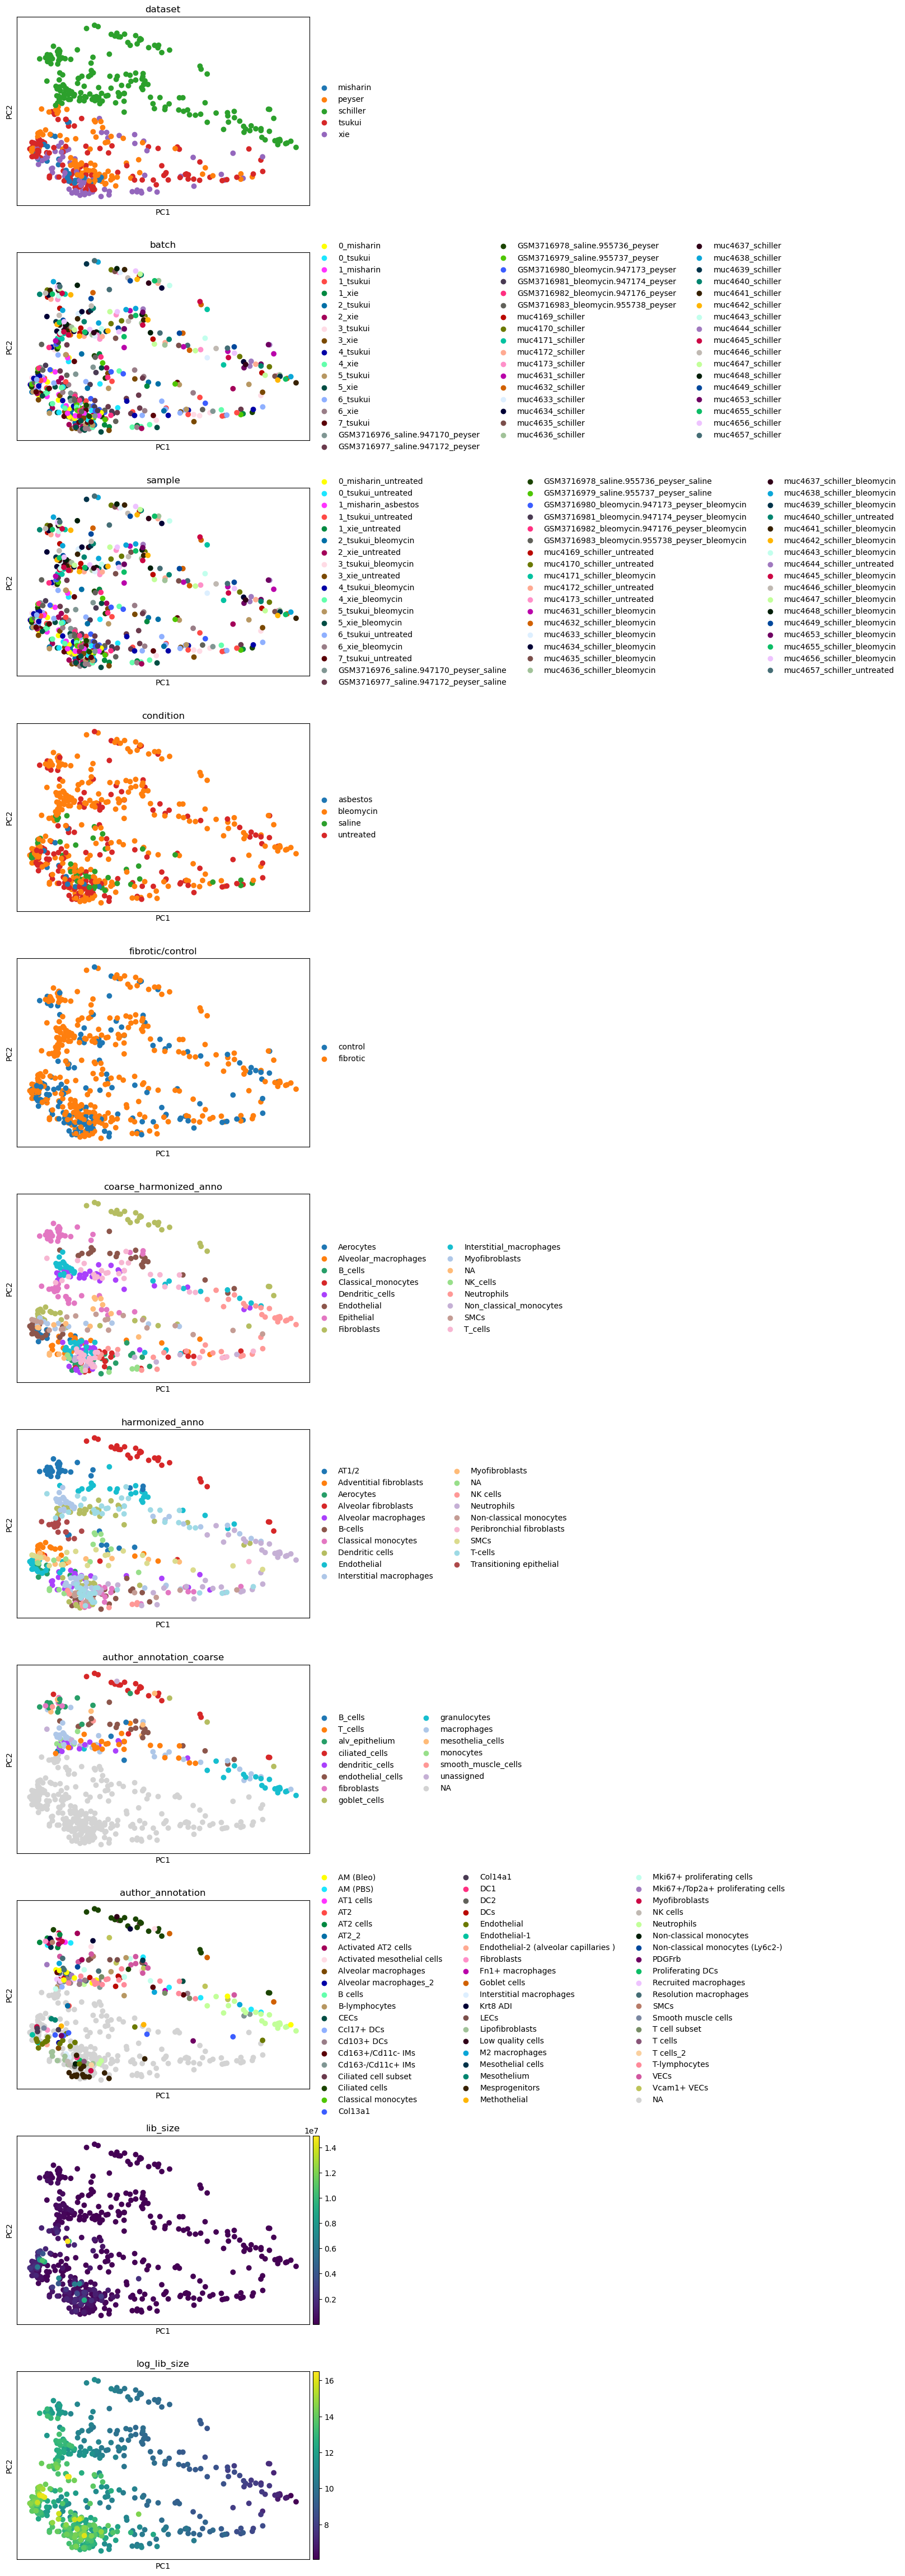

In [20]:
sc.pl.pca(adata_pb, color=adata_pb.obs, ncols=1, size=200)

In [21]:
adata_pb.X = adata_pb.layers['counts'].copy()

In [22]:
np.max(adata_pb.X)   # check if .X contains raw counts

2009926.0

[Text(0.5, 1.0, 'Pseudobulk - raw counts histogram'),
 Text(0, 0.5, 'Frequency')]

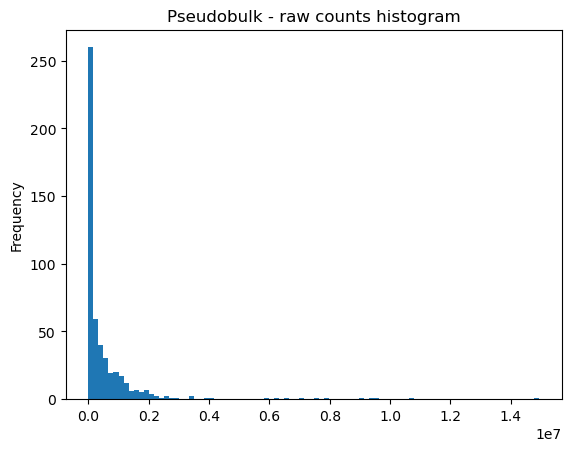

In [23]:
column_sums = np.sum(adata_pb.X, axis=1)
plt.hist(column_sums, bins=90)   # plot the sums of the raw counts as a sanity check
plt.gca().set(title='Pseudobulk - raw counts histogram', ylabel='Frequency')

In [24]:
# very important conversions as adata_pb.write() does not work otherwise 
adata_pb.X = np.vstack(adata_pb.X[:, :]).astype(float)
adata_pb.layers['counts'] = np.vstack(adata_pb.layers['counts'][:, :]).astype(float)

## Saving the annData object:

In [25]:
adata_pb.write("/home/sch/schonner/MaPra/merged_data_for_diffEx_edgeR.h5ad")